In [1]:
import os
import csv
import copy
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as Data
from sklearn.utils import shuffle as reset
from tqdm import tqdm
import transformers
from transformers import *
import visdom
import matplotlib.pyplot as plt



D:\anaconda\lib\site-packages\torchaudio\backend\utils.py:67: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [2]:
transformers.logging.set_verbosity_error()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
classes2idx = {'Neutral': 0, 'Negative': 1, 'Positive': 2}
idx2classes = {0: 'Neutral', 1: 'Negative', 2: 'Positive'}


In [3]:
model_name = 'bert-base-chinese'
output_model = r"model\model.pth"
best_score = 0
batch_size = 16

In [4]:
class CustomDataset(Data.Dataset):
    def __init__(self, data, maxlen, with_labels=True, model_name='bert-base-chinese'):
        self.data = data  # pandas dataframe

        # Initialize the tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.maxlen = maxlen
        self.with_labels = with_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        # Selecting sentence1 and sentence2 at the specified index in the data frame
        sent = str(self.data.loc[index, 'content'])

        # Tokenize the pair of sentences to get token ids, attention masks and token type ids
        encoded_pair = self.tokenizer(sent,
                                      padding='max_length',  # Pad to max_length
                                      truncation=True,  # Truncate to max_length
                                      max_length=self.maxlen,
                                      return_tensors='pt')  # Return torch.Tensor objects

        token_ids = encoded_pair['input_ids'].squeeze(0)  # tensor of token ids
        attn_masks = encoded_pair['attention_mask'].squeeze(
            0)  # binary tensor with "0" for padded values and "1" for the other values
        token_type_ids = encoded_pair['token_type_ids'].squeeze(
            0)  # binary tensor with "0" for the 1st sentence tokens & "1" for the 2nd sentence tokens
        #制定了三个张量
        if self.with_labels:  # True if the dataset has labels
            label = self.data.loc[index, 'class_label']
            return token_ids, attn_masks, token_type_ids, label
        else:
            return token_ids, attn_masks, token_type_ids

In [5]:
class MyModel(nn.Module):
    def __init__(self, freeze_bert=False, model_name='bert-base-chinese', hidden_size=768, num_classes=5):
        super(MyModel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name, output_hidden_states=True, return_dict=True)

        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False

        self.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(hidden_size * 4, num_classes, bias=True),
        )


    def forward(self, input_ids, attn_masks, token_type_ids):
        outputs = self.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attn_masks)
        hidden_states = torch.cat(tuple([outputs.hidden_states[i] for i in [-1, -2, -3, -4]]),
                                  dim=-1)  # [bs, seq_len, hidden_dim*4]
        first_hidden_states = hidden_states[:, 0, :]  # [bs, hidden_dim*4]
        #print(first_hidden_states)
        
        
        
        
        logits = self.fc(first_hidden_states)
        #print("logits=")
        #print(logits)
        return logits

In [6]:
def set_seed(seed):
    """ Set all seeds to make results reproducible """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [7]:

def process_data(filename, classes2idx, with_labels=True):
    data = pd.read_csv(filename)
    if with_labels:
        data = data.replace({'class_label': classes2idx})
    return data


In [8]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()  # [3, 5, 8, 1, 2, ....]
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [9]:
def save(model, optimizer):
    # save
    print('The best model has been saved')
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_model)
    

In [10]:
def train_test_split(data_df, valid_size=0.1, test_size=0.1, shuffle=True, random_state=None):
    if shuffle:
        data_df = reset(data_df, random_state=random_state)
    
    
    train = data_df[int(len(data_df) * (test_size+valid_size)):].reset_index(drop=True)
    test = data_df[:int(len(data_df) * test_size)].reset_index(drop=True)
    valid = data_df[int(len(data_df) * test_size):int(len(data_df) * (test_size+valid_size))].reset_index(drop=True)

    return train, valid, test

In [11]:
def train_eval(model, criterion, optimizer, train_loader, val_loader, test_loader, epochs=2):
    checkpoint = torch.load(output_model, map_location='cpu')
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    

    print('-----Training-----')
    for epoch in range(epochs):
        model.train()
        print('Epoch', epoch)
        for i, batch in enumerate(tqdm(train_loader)):
            batch = tuple(t.to(device) for t in batch)
            logits = model(batch[0], batch[1], batch[2])
            loss = criterion(logits, batch[3])
            times.append(i)
            Loss_list.append(loss.item())
            #print(i," loss=",loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 8 == 0:
                eval(model, optimizer, val_loader, train_loader,test_loader)

In [12]:
def eval(model, optimizer, validation_dataloader, train_dataloader, test_dataloader):

    model.eval()
    eval_loss, eval_accuracy, nb_eval_steps = 0, 0, 0
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            logits = model(batch[0], batch[1], batch[2])
            logits = logits.detach().cpu().numpy()
            label_ids = batch[3].cpu().numpy()
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            eval_accuracy += tmp_eval_accuracy
            nb_eval_steps += 1
    Accuracy_list.append(eval_accuracy / nb_eval_steps)
    print("Validation Accuracy: {}".format(eval_accuracy / nb_eval_steps))
    
   # 
   # teval_loss, teval_accuracy, tnb_eval_steps = 0, 0, 0
   # for tbatch in train_dataloader:
   #     tbatch = tuple(t.to(device) for t in tbatch)
   #     with torch.no_grad():
   #         tlogits = model(tbatch[0], tbatch[1], tbatch[2])
   #         tlogits = tlogits.detach().cpu().numpy()
   #         tlabel_ids = tbatch[3].cpu().numpy()
   #         ttmp_eval_accuracy = flat_accuracy(tlogits, tlabel_ids)
   #         teval_accuracy += ttmp_eval_accuracy
   #         tnb_eval_steps += 1
   # print("Train Accuracy: {}".format(teval_accuracy / tnb_eval_steps))
   # Train_list.append(teval_accuracy / tnb_eval_steps)
   # 
    teeval_loss, teeval_accuracy, tenb_eval_steps = 0, 0, 0
    for tebatch in test_dataloader:
        tebatch = tuple(t.to(device) for t in tebatch)
        with torch.no_grad():
            telogits = model(tebatch[0], tebatch[1], tebatch[2])
            telogits = telogits.detach().cpu().numpy()
            telabel_ids = tebatch[3].cpu().numpy()
            tetmp_eval_accuracy = flat_accuracy(telogits, telabel_ids)
            teeval_accuracy += tetmp_eval_accuracy
            tenb_eval_steps += 1
    print("Test Accuracy: {}".format(teeval_accuracy / tenb_eval_steps))
    Test_list.append(teeval_accuracy / tenb_eval_steps)  


    
    global best_score
    if best_score < eval_accuracy / nb_eval_steps:
        best_score = eval_accuracy / nb_eval_steps
        save(model, optimizer)

In [13]:
def test(model, dataloader, with_labels=False):
    # load model
    checkpoint = torch.load(output_model, map_location='cpu')

    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    print('-----Testing-----')

    pred_label = []
    model.eval()
    for i, batch in enumerate(tqdm(classify_loader)):
        batch = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            logits = model(batch[0], batch[1], batch[2])
            logits = logits.detach().cpu().numpy()
            preds = np.argmax(logits, axis=1).flatten()
            pred_label.extend(preds)

    pd.DataFrame(data=pred_label, index=range(len(pred_label))).to_csv(r'data\testpred.csv', index=False, header=['class_label'],
                                                                       encoding='utf-8')

    rel_dict = idx2classes
    pred = pd.read_csv(r"data\testpred.csv")
    result = pd.read_csv(test_data)
    result["pre_label"]=pred["class_label"]
    result.to_csv(r"data\testresult.csv",  index=False, encoding='utf-8-sig')
    print('Classify Completed')

In [14]:
def classify(model, dataloader, with_labels=False):
    # load model
    checkpoint = torch.load(output_model, map_location='cpu')

    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    print('-----Classify-----')

    pred_label = []
    model.eval()
    for i, batch in enumerate(tqdm(classify_loader)):
        batch = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            logits = model(batch[0], batch[1], batch[2])
            logits = logits.detach().cpu().numpy()
            preds = np.argmax(logits, axis=1).flatten()
            pred_label.extend(preds)

    pd.DataFrame(data=pred_label, index=range(len(pred_label))).to_csv(r'data\pred.csv', index=False, header=['class_label'],
                                                                       encoding='utf-8')

    rel_dict = idx2classes
    pred = pd.read_csv(r"data\pred.csv")
    result = pd.read_csv(classify_data)
    result["pre_label"]=pred["class_label"]
    result = result.replace({'pre_label': idx2classes})
    result.to_csv(r"data\2021classifyresult.csv", index=False, encoding='utf-8-sig')
    print('Classify Completed')

In [15]:
def countdata():
    print('-----count data-----')
    stock = pd.read_csv(r"data\2021stock - 副本.csv")
    comment = pd.read_csv(r"data\2021classifyresult.csv")
    
    time_list = []
    for i in range(0,len(stock)):
        riqi_nian = str(stock["date"][i])
        rizi = riqi_nian
        time_list.append(rizi)
        
    Positive = comment[comment['pre_label'] == 'Positive']
    Neutral = comment[comment['pre_label'] == 'Neutral']
    Negative = comment[comment['pre_label'] == 'Negative']
    Positive_list = []
    Neutral_list = []
    Negative_list = []
    
    for i in tqdm(range(0,len(stock))):
        l = len(Negative[Negative['date'] == time_list[i]])
        Negative_list.append(l)
        

        j = len(Neutral[Neutral['date'] == time_list[i]])
        Neutral_list.append(j)
        

        k = len(Positive[Positive['date'] == time_list[i]])
        Positive_list.append(k)   
        
    count =pd.DataFrame()
    
    count['Negative']=Negative_list
    count['Neutral']=Neutral_list
    count['Positive']=Positive_list
    count = count+1
    count.to_csv(r"data\2021count.csv", encoding='utf-8-sig')
    
    
    stock['Negative']=count['Negative']
    stock['Neutral']=count['Neutral']
    stock['Positive']=count['Positive']
    stock.to_csv(r"data\2021stockdata.csv", encoding='utf-8-sig',index = False)


Reading training data...
Reading validation data...
Reading test data...
save the first model


  0%|          | 0/750 [00:00<?, ?it/s]

-----Training-----
Epoch 0
Validation Accuracy: 0.31183510638297873
Test Accuracy: 0.3184840425531915
The best model has been saved


  1%|          | 8/750 [00:17<18:49,  1.52s/it]  

Validation Accuracy: 0.504654255319149
Test Accuracy: 0.46232269503546103
The best model has been saved


  2%|▏         | 16/750 [00:33<07:58,  1.53it/s] 

Validation Accuracy: 0.5139627659574468
Test Accuracy: 0.47052304964539005
The best model has been saved


  3%|▎         | 24/750 [00:49<06:59,  1.73it/s]

Validation Accuracy: 0.5070921985815603


  3%|▎         | 25/750 [01:01<49:34,  4.10s/it]

Test Accuracy: 0.46165780141843976


  4%|▍         | 32/750 [01:02<08:02,  1.49it/s]

Validation Accuracy: 0.5356826241134751
Test Accuracy: 0.49357269503546103
The best model has been saved


  5%|▌         | 40/750 [01:18<06:58,  1.70it/s]

Validation Accuracy: 0.6128102836879432
Test Accuracy: 0.5822251773049645
The best model has been saved


  6%|▋         | 48/750 [01:34<08:57,  1.31it/s]

Validation Accuracy: 0.6110372340425532


  7%|▋         | 49/750 [01:46<49:29,  4.24s/it]

Test Accuracy: 0.5859929078014184


  7%|▋         | 56/750 [01:48<07:56,  1.46it/s]

Validation Accuracy: 0.6265514184397163
Test Accuracy: 0.599290780141844
The best model has been saved


  9%|▊         | 64/750 [02:03<08:32,  1.34it/s]

Validation Accuracy: 0.6300975177304964
Test Accuracy: 0.6136968085106383
The best model has been saved


 10%|▉         | 72/750 [02:20<08:59,  1.26it/s]

Validation Accuracy: 0.6376329787234043
Test Accuracy: 0.6256648936170213
The best model has been saved


 11%|█         | 80/750 [02:36<08:28,  1.32it/s]

Validation Accuracy: 0.699468085106383
Test Accuracy: 0.6839539007092199
The best model has been saved


 12%|█▏        | 88/750 [02:51<08:39,  1.28it/s]

Validation Accuracy: 0.7169769503546098
Test Accuracy: 0.7005762411347518
The best model has been saved


 13%|█▎        | 96/750 [03:08<08:45,  1.24it/s]

Validation Accuracy: 0.7005762411347518


 13%|█▎        | 97/750 [03:21<46:30,  4.27s/it]

Test Accuracy: 0.6819592198581561


 14%|█▍        | 104/750 [03:22<07:27,  1.44it/s]

Validation Accuracy: 0.742686170212766
Test Accuracy: 0.7287234042553191
The best model has been saved


 15%|█▍        | 112/750 [03:37<07:54,  1.35it/s]

Validation Accuracy: 0.7369237588652482


 15%|█▌        | 113/750 [03:50<44:43,  4.21s/it]

Test Accuracy: 0.7136524822695035


 16%|█▌        | 120/750 [03:51<07:10,  1.46it/s]

Validation Accuracy: 0.7506648936170213
Test Accuracy: 0.7229609929078014
The best model has been saved


 17%|█▋        | 128/750 [04:07<07:40,  1.35it/s]

Validation Accuracy: 0.7393617021276596


 17%|█▋        | 129/750 [04:20<47:15,  4.57s/it]

Test Accuracy: 0.7156471631205673


 18%|█▊        | 136/750 [04:22<07:39,  1.34it/s]

Validation Accuracy: 0.7728280141843971
Test Accuracy: 0.749113475177305
The best model has been saved


 19%|█▉        | 144/750 [04:39<06:31,  1.55it/s]

Validation Accuracy: 0.7865691489361702
Test Accuracy: 0.7579787234042553
The best model has been saved


 20%|██        | 152/750 [04:55<05:53,  1.69it/s]

Validation Accuracy: 0.7918882978723404
Test Accuracy: 0.7845744680851063
The best model has been saved


 21%|██▏       | 160/750 [05:11<07:22,  1.33it/s]

Validation Accuracy: 0.8027482269503545
Test Accuracy: 0.7819148936170213
The best model has been saved


 22%|██▏       | 168/750 [05:26<07:19,  1.32it/s]

Validation Accuracy: 0.785904255319149


 23%|██▎       | 169/750 [05:39<41:07,  4.25s/it]

Test Accuracy: 0.7688386524822695


 23%|██▎       | 176/750 [05:40<06:40,  1.43it/s]

Validation Accuracy: 0.8209219858156029
Test Accuracy: 0.7983156028368795
The best model has been saved


 25%|██▍       | 184/750 [05:56<07:02,  1.34it/s]

Validation Accuracy: 0.819813829787234


 25%|██▍       | 186/750 [06:09<30:00,  3.19s/it]

Test Accuracy: 0.7972074468085106


 26%|██▌       | 192/750 [06:11<05:31,  1.69it/s]

Validation Accuracy: 0.807845744680851


 26%|██▌       | 193/750 [06:24<40:22,  4.35s/it]

Test Accuracy: 0.7998670212765957


 27%|██▋       | 200/750 [06:25<06:32,  1.40it/s]

Validation Accuracy: 0.8151595744680851


 27%|██▋       | 201/750 [06:38<39:05,  4.27s/it]

Test Accuracy: 0.7914450354609929


 28%|██▊       | 208/750 [06:39<06:14,  1.45it/s]

Validation Accuracy: 0.8246897163120567
Test Accuracy: 0.8102836879432624
The best model has been saved


 29%|██▉       | 216/750 [06:55<06:46,  1.31it/s]

Validation Accuracy: 0.8266843971631205
Test Accuracy: 0.8036347517730497
The best model has been saved


 30%|██▉       | 224/750 [07:12<05:25,  1.62it/s]

Validation Accuracy: 0.8246897163120567


 30%|███       | 225/750 [07:24<36:58,  4.23s/it]

Test Accuracy: 0.8058510638297872


 31%|███       | 232/750 [07:26<05:55,  1.46it/s]

Validation Accuracy: 0.8337765957446809
Test Accuracy: 0.8011968085106383
The best model has been saved


 32%|███▏      | 240/750 [07:41<05:00,  1.70it/s]

Validation Accuracy: 0.8293439716312057


 32%|███▏      | 241/750 [07:54<35:06,  4.14s/it]

Test Accuracy: 0.8093971631205673


 33%|███▎      | 248/750 [07:55<05:39,  1.48it/s]

Validation Accuracy: 0.8255762411347518


 33%|███▎      | 249/750 [08:08<34:57,  4.19s/it]

Test Accuracy: 0.7972074468085106


 34%|███▍      | 256/750 [08:09<05:39,  1.45it/s]

Validation Accuracy: 0.8421985815602837
Test Accuracy: 0.8076241134751774
The best model has been saved


 35%|███▌      | 264/750 [08:25<04:48,  1.68it/s]

Validation Accuracy: 0.8262411347517731


 35%|███▌      | 265/750 [08:37<33:49,  4.18s/it]

Test Accuracy: 0.8160460992907801


 36%|███▋      | 272/750 [08:39<05:28,  1.45it/s]

Validation Accuracy: 0.851063829787234
Test Accuracy: 0.8207003546099291
The best model has been saved


 37%|███▋      | 280/750 [08:55<05:57,  1.32it/s]

Validation Accuracy: 0.8506205673758864


 37%|███▋      | 281/750 [09:07<33:45,  4.32s/it]

Test Accuracy: 0.8280141843971631


 38%|███▊      | 288/750 [09:09<05:21,  1.44it/s]

Validation Accuracy: 0.832668439716312


 39%|███▊      | 289/750 [09:21<32:25,  4.22s/it]

Test Accuracy: 0.8169326241134752


 39%|███▉      | 296/750 [09:22<05:11,  1.46it/s]

Validation Accuracy: 0.839982269503546


 40%|███▉      | 297/750 [09:35<31:44,  4.20s/it]

Test Accuracy: 0.8164893617021277


 41%|████      | 304/750 [09:36<05:04,  1.47it/s]

Validation Accuracy: 0.8479609929078014


 41%|████      | 305/750 [09:49<31:32,  4.25s/it]

Test Accuracy: 0.8295656028368795


 42%|████▏     | 312/750 [09:50<05:02,  1.45it/s]

Validation Accuracy: 0.8537234042553191
Test Accuracy: 0.8355496453900709
The best model has been saved


 43%|████▎     | 320/750 [10:06<04:16,  1.68it/s]

Validation Accuracy: 0.8526152482269503


 43%|████▎     | 321/750 [10:19<30:04,  4.21s/it]

Test Accuracy: 0.8386524822695035


 44%|████▎     | 328/750 [10:20<04:48,  1.46it/s]

Validation Accuracy: 0.8563829787234043
Test Accuracy: 0.8419769503546098
The best model has been saved


 45%|████▍     | 336/750 [10:36<05:09,  1.34it/s]

Validation Accuracy: 0.8535017730496455


 45%|████▍     | 337/750 [10:48<29:24,  4.27s/it]

Test Accuracy: 0.8481826241134752


 46%|████▌     | 344/750 [10:50<04:43,  1.43it/s]

Validation Accuracy: 0.8537234042553191


 46%|████▌     | 345/750 [11:02<28:43,  4.25s/it]

Test Accuracy: 0.8466312056737588


 47%|████▋     | 352/750 [11:04<04:33,  1.45it/s]

Validation Accuracy: 0.870345744680851
Test Accuracy: 0.8583776595744681
The best model has been saved


 48%|████▊     | 360/750 [11:19<04:51,  1.34it/s]

Validation Accuracy: 0.8714539007092199
Test Accuracy: 0.8439716312056738
The best model has been saved


 49%|████▉     | 368/750 [11:35<04:46,  1.33it/s]

Validation Accuracy: 0.8732269503546098
Test Accuracy: 0.8530585106382979
The best model has been saved


 50%|█████     | 376/750 [11:51<03:40,  1.69it/s]

Validation Accuracy: 0.8654698581560284


 50%|█████     | 377/750 [12:03<25:44,  4.14s/it]

Test Accuracy: 0.8528368794326242


 51%|█████     | 384/750 [12:04<04:09,  1.47it/s]

Validation Accuracy: 0.8772163120567376
Test Accuracy: 0.8581560283687943
The best model has been saved


 52%|█████▏    | 392/750 [12:20<04:27,  1.34it/s]

Validation Accuracy: 0.8707890070921986


 52%|█████▏    | 393/750 [12:32<25:22,  4.26s/it]

Test Accuracy: 0.8599290780141844


 53%|█████▎    | 400/750 [12:34<04:02,  1.44it/s]

Validation Accuracy: 0.875


 53%|█████▎    | 401/750 [12:46<24:39,  4.24s/it]

Test Accuracy: 0.8601507092198583


 54%|█████▍    | 408/750 [12:48<03:56,  1.45it/s]

Validation Accuracy: 0.874113475177305


 55%|█████▍    | 409/750 [13:00<23:40,  4.17s/it]

Test Accuracy: 0.8648049645390071


 55%|█████▌    | 416/750 [13:02<03:46,  1.47it/s]

Validation Accuracy: 0.8730053191489362


 56%|█████▌    | 417/750 [13:14<23:20,  4.21s/it]

Test Accuracy: 0.8663563829787234


 57%|█████▋    | 424/750 [13:15<03:43,  1.46it/s]

Validation Accuracy: 0.8696808510638298


 57%|█████▋    | 425/750 [13:28<22:49,  4.21s/it]

Test Accuracy: 0.8535017730496455


 58%|█████▊    | 432/750 [13:29<03:40,  1.44it/s]

Validation Accuracy: 0.8643617021276596


 58%|█████▊    | 433/750 [13:42<22:17,  4.22s/it]

Test Accuracy: 0.8543882978723404


 59%|█████▊    | 440/750 [13:43<03:32,  1.46it/s]

Validation Accuracy: 0.8807624113475178
Test Accuracy: 0.8672429078014184
The best model has been saved


 60%|█████▉    | 448/750 [13:59<02:58,  1.69it/s]

Validation Accuracy: 0.847517730496454


 60%|█████▉    | 449/750 [14:11<20:58,  4.18s/it]

Test Accuracy: 0.8359929078014184


 61%|██████    | 456/750 [14:13<03:20,  1.47it/s]

Validation Accuracy: 0.875


 61%|██████    | 457/750 [14:25<20:31,  4.20s/it]

Test Accuracy: 0.8654698581560284


 62%|██████▏   | 464/750 [14:27<03:15,  1.46it/s]

Validation Accuracy: 0.868572695035461


 62%|██████▏   | 465/750 [14:39<19:59,  4.21s/it]

Test Accuracy: 0.8623670212765957


 63%|██████▎   | 472/750 [14:41<03:10,  1.46it/s]

Validation Accuracy: 0.8805407801418439


 63%|██████▎   | 473/750 [14:53<19:24,  4.21s/it]

Test Accuracy: 0.8636968085106383


 64%|██████▍   | 480/750 [14:54<03:05,  1.46it/s]

Validation Accuracy: 0.8820921985815603
Test Accuracy: 0.8663563829787234
The best model has been saved


 65%|██████▌   | 488/750 [15:10<02:35,  1.69it/s]

Validation Accuracy: 0.8845301418439716
Test Accuracy: 0.868572695035461
The best model has been saved


 66%|██████▌   | 496/750 [15:26<02:30,  1.68it/s]

Validation Accuracy: 0.8856382978723404
Test Accuracy: 0.8727836879432624
The best model has been saved


 67%|██████▋   | 504/750 [15:42<02:23,  1.71it/s]

Validation Accuracy: 0.8579343971631205


 67%|██████▋   | 505/750 [15:54<16:54,  4.14s/it]

Test Accuracy: 0.8495124113475178


 68%|██████▊   | 512/750 [15:56<02:40,  1.48it/s]

Validation Accuracy: 0.8794326241134752


 68%|██████▊   | 513/750 [16:08<16:37,  4.21s/it]

Test Accuracy: 0.8641400709219859


 69%|██████▉   | 520/750 [16:09<02:37,  1.46it/s]

Validation Accuracy: 0.8803191489361702


 69%|██████▉   | 521/750 [16:22<16:07,  4.23s/it]

Test Accuracy: 0.8597074468085106


 70%|███████   | 528/750 [16:23<02:35,  1.43it/s]

Validation Accuracy: 0.881427304964539


 71%|███████   | 529/750 [16:36<15:38,  4.25s/it]

Test Accuracy: 0.863918439716312


 71%|███████▏  | 536/750 [16:37<02:27,  1.45it/s]

Validation Accuracy: 0.8896276595744681
Test Accuracy: 0.8652482269503545
The best model has been saved


 73%|███████▎  | 544/750 [16:53<02:33,  1.34it/s]

Validation Accuracy: 0.875


 73%|███████▎  | 545/750 [17:05<14:30,  4.25s/it]

Test Accuracy: 0.8690159574468085


 74%|███████▎  | 552/750 [17:07<02:18,  1.43it/s]

Validation Accuracy: 0.8721187943262412


 74%|███████▎  | 553/750 [17:19<14:01,  4.27s/it]

Test Accuracy: 0.863031914893617


 75%|███████▍  | 560/750 [17:21<02:11,  1.44it/s]

Validation Accuracy: 0.8807624113475178


 75%|███████▍  | 561/750 [17:33<13:16,  4.21s/it]

Test Accuracy: 0.8756648936170213


 76%|███████▌  | 568/750 [17:35<02:04,  1.46it/s]

Validation Accuracy: 0.8800975177304965


 76%|███████▌  | 570/750 [17:47<08:54,  2.97s/it]

Test Accuracy: 0.8714539007092199


 77%|███████▋  | 576/750 [17:48<01:34,  1.85it/s]

Validation Accuracy: 0.8623670212765957


 77%|███████▋  | 577/750 [18:01<11:54,  4.13s/it]

Test Accuracy: 0.8470744680851063


 78%|███████▊  | 584/750 [18:02<01:52,  1.47it/s]

Validation Accuracy: 0.8785460992907801


 78%|███████▊  | 585/750 [18:15<11:50,  4.31s/it]

Test Accuracy: 0.8707890070921986


 79%|███████▉  | 592/750 [18:17<01:50,  1.44it/s]

Validation Accuracy: 0.8845301418439716


 79%|███████▉  | 593/750 [18:29<11:08,  4.26s/it]

Test Accuracy: 0.8807624113475178


 80%|████████  | 600/750 [18:31<01:45,  1.43it/s]

Validation Accuracy: 0.8871897163120567


 80%|████████  | 601/750 [18:43<10:32,  4.24s/it]

Test Accuracy: 0.8694592198581561


 81%|████████  | 608/750 [18:44<01:37,  1.45it/s]

Validation Accuracy: 0.8772163120567376


 81%|████████  | 609/750 [18:57<09:52,  4.20s/it]

Test Accuracy: 0.8574911347517731


 82%|████████▏ | 616/750 [18:58<01:31,  1.46it/s]

Validation Accuracy: 0.8772163120567376


 82%|████████▏ | 617/750 [19:11<09:20,  4.21s/it]

Test Accuracy: 0.8781028368794327


 83%|████████▎ | 624/750 [19:12<01:26,  1.46it/s]

Validation Accuracy: 0.863918439716312


 83%|████████▎ | 625/750 [19:25<08:57,  4.30s/it]

Test Accuracy: 0.8643617021276596


 84%|████████▍ | 632/750 [19:26<01:22,  1.44it/s]

Validation Accuracy: 0.8836436170212766


 84%|████████▍ | 633/750 [19:39<08:10,  4.20s/it]

Test Accuracy: 0.8718971631205673


 85%|████████▌ | 640/750 [19:40<01:16,  1.45it/s]

Validation Accuracy: 0.8754432624113476


 85%|████████▌ | 641/750 [19:52<07:38,  4.21s/it]

Test Accuracy: 0.8648049645390071


 86%|████████▋ | 648/750 [19:54<01:09,  1.46it/s]

Validation Accuracy: 0.8812056737588652


 87%|████████▋ | 649/750 [20:06<07:04,  4.21s/it]

Test Accuracy: 0.8699024822695035


 87%|████████▋ | 656/750 [20:08<01:04,  1.46it/s]

Validation Accuracy: 0.8687943262411348


 88%|████████▊ | 657/750 [20:20<06:32,  4.23s/it]

Test Accuracy: 0.8732269503546098


 89%|████████▊ | 664/750 [20:22<01:00,  1.43it/s]

Validation Accuracy: 0.8854166666666667


 89%|████████▊ | 665/750 [20:34<05:58,  4.22s/it]

Test Accuracy: 0.867686170212766


 90%|████████▉ | 672/750 [20:36<00:53,  1.46it/s]

Validation Accuracy: 0.8832003546099291


 90%|████████▉ | 673/750 [20:48<05:23,  4.21s/it]

Test Accuracy: 0.867686170212766


 91%|█████████ | 680/750 [20:49<00:47,  1.46it/s]

Validation Accuracy: 0.8882978723404256


 91%|█████████ | 681/750 [21:02<04:49,  4.20s/it]

Test Accuracy: 0.878767730496454


 92%|█████████▏| 688/750 [21:03<00:42,  1.46it/s]

Validation Accuracy: 0.8898492907801417
Test Accuracy: 0.8845301418439716
The best model has been saved


 93%|█████████▎| 696/750 [21:19<00:40,  1.34it/s]

Validation Accuracy: 0.8867464539007093


 93%|█████████▎| 697/750 [21:31<03:45,  4.25s/it]

Test Accuracy: 0.8834219858156029


 94%|█████████▍| 704/750 [21:33<00:31,  1.45it/s]

Validation Accuracy: 0.8880762411347518


 94%|█████████▍| 705/750 [21:45<03:09,  4.21s/it]

Test Accuracy: 0.8851950354609929


 95%|█████████▍| 712/750 [21:46<00:25,  1.46it/s]

Validation Accuracy: 0.8812056737588652


 95%|█████████▌| 713/750 [21:59<02:35,  4.21s/it]

Test Accuracy: 0.8772163120567376


 96%|█████████▌| 720/750 [22:00<00:20,  1.46it/s]

Validation Accuracy: 0.8871897163120567


 96%|█████████▋| 722/750 [22:13<01:24,  3.00s/it]

Test Accuracy: 0.881427304964539


 97%|█████████▋| 728/750 [22:14<00:12,  1.82it/s]

Validation Accuracy: 0.8732269503546098


 97%|█████████▋| 729/750 [22:27<01:28,  4.21s/it]

Test Accuracy: 0.8656914893617021


 98%|█████████▊| 736/750 [22:28<00:09,  1.45it/s]

Validation Accuracy: 0.8914007092198583
Test Accuracy: 0.8900709219858156
The best model has been saved


 99%|█████████▉| 744/750 [22:44<00:04,  1.31it/s]

Validation Accuracy: 0.8730053191489362


 99%|█████████▉| 745/750 [22:57<00:21,  4.28s/it]

Test Accuracy: 0.8667996453900709


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1
Validation Accuracy: 0.8623670212765957


  0%|          | 1/750 [00:12<2:37:06, 12.59s/it]

Test Accuracy: 0.8521719858156029


  1%|          | 8/750 [00:13<20:38,  1.67s/it]  

Validation Accuracy: 0.8880762411347518


  1%|          | 9/750 [00:26<1:00:26,  4.89s/it]

Test Accuracy: 0.8947251773049646


  2%|▏         | 16/750 [00:27<09:23,  1.30it/s] 

Validation Accuracy: 0.8694592198581561


  2%|▏         | 17/750 [00:40<52:38,  4.31s/it]

Test Accuracy: 0.8845301418439716


  3%|▎         | 24/750 [00:41<08:26,  1.43it/s]

Validation Accuracy: 0.8909574468085106


  3%|▎         | 25/750 [00:54<51:31,  4.26s/it]

Test Accuracy: 0.8922872340425532


  4%|▍         | 32/750 [00:55<08:15,  1.45it/s]

Validation Accuracy: 0.8882978723404256


  5%|▍         | 34/750 [01:08<35:45,  3.00s/it]

Test Accuracy: 0.8896276595744681


  5%|▌         | 40/750 [01:09<06:28,  1.83it/s]

Validation Accuracy: 0.8818705673758864


  5%|▌         | 41/750 [01:22<48:43,  4.12s/it]

Test Accuracy: 0.881427304964539


  6%|▋         | 48/750 [01:23<07:53,  1.48it/s]

Validation Accuracy: 0.8867464539007093


  7%|▋         | 49/750 [01:36<49:05,  4.20s/it]

Test Accuracy: 0.8865248226950354


  7%|▋         | 56/750 [01:37<07:56,  1.46it/s]

Validation Accuracy: 0.8911790780141844


  8%|▊         | 57/750 [01:49<48:53,  4.23s/it]

Test Accuracy: 0.8874113475177305


  9%|▊         | 64/750 [01:51<07:51,  1.45it/s]

Validation Accuracy: 0.886081560283688


  9%|▊         | 65/750 [02:03<48:01,  4.21s/it]

Test Accuracy: 0.8887411347517731


 10%|▉         | 72/750 [02:05<07:45,  1.46it/s]

Validation Accuracy: 0.8840868794326242


 10%|▉         | 73/750 [02:17<47:50,  4.24s/it]

Test Accuracy: 0.8887411347517731


 11%|█         | 80/750 [02:19<07:41,  1.45it/s]

Validation Accuracy: 0.8867464539007093


 11%|█         | 81/750 [02:31<46:34,  4.18s/it]

Test Accuracy: 0.8898492907801417


 12%|█▏        | 88/750 [02:32<07:32,  1.46it/s]

Validation Accuracy: 0.8827570921985816


 12%|█▏        | 89/750 [02:45<46:10,  4.19s/it]

Test Accuracy: 0.8900709219858156


 13%|█▎        | 96/750 [02:46<07:29,  1.46it/s]

Validation Accuracy: 0.8874113475177305


 13%|█▎        | 97/750 [02:59<46:00,  4.23s/it]

Test Accuracy: 0.8812056737588652


 14%|█▍        | 104/750 [03:00<07:25,  1.45it/s]

Validation Accuracy: 0.8854166666666667


 14%|█▍        | 105/750 [03:13<45:55,  4.27s/it]

Test Accuracy: 0.8754432624113476


 15%|█▍        | 112/750 [03:14<07:21,  1.45it/s]

Validation Accuracy: 0.8794326241134752


 15%|█▌        | 113/750 [03:27<45:10,  4.25s/it]

Test Accuracy: 0.8692375886524822


 16%|█▌        | 120/750 [03:28<07:17,  1.44it/s]

Validation Accuracy: 0.8785460992907801


 16%|█▌        | 121/750 [03:41<44:33,  4.25s/it]

Test Accuracy: 0.875


 17%|█▋        | 128/750 [03:42<07:08,  1.45it/s]

Validation Accuracy: 0.8803191489361702


 17%|█▋        | 129/750 [03:55<43:54,  4.24s/it]

Test Accuracy: 0.8832003546099291


 18%|█▊        | 136/750 [03:56<07:06,  1.44it/s]

Validation Accuracy: 0.8863031914893617


 18%|█▊        | 137/750 [04:09<43:32,  4.26s/it]

Test Accuracy: 0.886081560283688


 19%|█▉        | 144/750 [04:10<06:58,  1.45it/s]

Validation Accuracy: 0.8909574468085106


 19%|█▉        | 145/750 [04:23<42:52,  4.25s/it]

Test Accuracy: 0.8854166666666667


 20%|██        | 152/750 [04:24<06:52,  1.45it/s]

Validation Accuracy: 0.8800975177304965


 20%|██        | 153/750 [04:36<41:59,  4.22s/it]

Test Accuracy: 0.8851950354609929


 21%|██▏       | 160/750 [04:38<06:55,  1.42it/s]

Validation Accuracy: 0.8829787234042553


 21%|██▏       | 161/750 [04:50<41:44,  4.25s/it]

Test Accuracy: 0.8854166666666667


 22%|██▏       | 168/750 [04:52<06:45,  1.44it/s]

Validation Accuracy: 0.8809840425531915


 23%|██▎       | 170/750 [05:05<29:19,  3.03s/it]

Test Accuracy: 0.870345744680851


 23%|██▎       | 176/750 [05:06<05:15,  1.82it/s]

Validation Accuracy: 0.8876329787234043


 24%|██▎       | 177/750 [05:19<40:03,  4.19s/it]

Test Accuracy: 0.8838652482269503


 25%|██▍       | 184/750 [05:20<06:31,  1.45it/s]

Validation Accuracy: 0.894281914893617
Test Accuracy: 0.8914007092198583
The best model has been saved


 26%|██▌       | 192/750 [05:36<05:30,  1.69it/s]

Validation Accuracy: 0.8918439716312057


 26%|██▌       | 193/750 [05:48<38:28,  4.14s/it]

Test Accuracy: 0.8898492907801417


 27%|██▋       | 200/750 [05:50<06:13,  1.47it/s]

Validation Accuracy: 0.8891843971631205


 27%|██▋       | 201/750 [06:02<38:59,  4.26s/it]

Test Accuracy: 0.8836436170212766


 28%|██▊       | 208/750 [06:04<06:14,  1.45it/s]

Validation Accuracy: 0.8927304964539008


 28%|██▊       | 209/750 [06:16<38:47,  4.30s/it]

Test Accuracy: 0.8945035460992907


 29%|██▉       | 216/750 [06:18<06:12,  1.43it/s]

Validation Accuracy: 0.8927304964539008


 29%|██▉       | 217/750 [06:30<37:29,  4.22s/it]

Test Accuracy: 0.8907358156028369


 30%|██▉       | 224/750 [06:32<06:02,  1.45it/s]

Validation Accuracy: 0.8936170212765957


 30%|███       | 225/750 [06:44<37:02,  4.23s/it]

Test Accuracy: 0.8940602836879433


 31%|███       | 232/750 [06:46<05:55,  1.46it/s]

Validation Accuracy: 0.8871897163120567


 31%|███       | 233/750 [06:58<36:40,  4.26s/it]

Test Accuracy: 0.8887411347517731


 32%|███▏      | 240/750 [07:00<05:55,  1.44it/s]

Validation Accuracy: 0.8878546099290779


 32%|███▏      | 241/750 [07:13<37:15,  4.39s/it]

Test Accuracy: 0.8838652482269503


 33%|███▎      | 248/750 [07:14<05:58,  1.40it/s]

Validation Accuracy: 0.8900709219858156


 33%|███▎      | 249/750 [07:28<38:18,  4.59s/it]

Test Accuracy: 0.8854166666666667


 34%|███▍      | 256/750 [07:29<06:00,  1.37it/s]

Validation Accuracy: 0.8847517730496455


 34%|███▍      | 257/750 [07:42<34:43,  4.23s/it]

Test Accuracy: 0.8887411347517731


 35%|███▌      | 264/750 [07:43<05:33,  1.46it/s]

Validation Accuracy: 0.8840868794326242


 35%|███▌      | 265/750 [07:56<34:42,  4.29s/it]

Test Accuracy: 0.8882978723404256


 36%|███▋      | 272/750 [07:57<05:32,  1.44it/s]

Validation Accuracy: 0.8905141843971631


 36%|███▋      | 273/750 [08:10<33:39,  4.23s/it]

Test Accuracy: 0.8916223404255319


 37%|███▋      | 280/750 [08:11<05:23,  1.45it/s]

Validation Accuracy: 0.8825354609929078


 37%|███▋      | 281/750 [08:23<32:58,  4.22s/it]

Test Accuracy: 0.8916223404255319


 38%|███▊      | 288/750 [08:25<05:16,  1.46it/s]

Validation Accuracy: 0.8718971631205673


 39%|███▊      | 289/750 [08:37<32:14,  4.20s/it]

Test Accuracy: 0.8710106382978723


 39%|███▉      | 296/750 [08:39<05:10,  1.46it/s]

Validation Accuracy: 0.8851950354609929


 40%|███▉      | 297/750 [08:51<32:13,  4.27s/it]

Test Accuracy: 0.8843085106382979


 41%|████      | 304/750 [08:53<05:08,  1.45it/s]

Validation Accuracy: 0.8832003546099291


 41%|████      | 306/750 [09:05<22:04,  2.98s/it]

Test Accuracy: 0.8871897163120567


 42%|████▏     | 312/750 [09:07<03:57,  1.85it/s]

Validation Accuracy: 0.8871897163120567


 42%|████▏     | 313/750 [09:19<29:48,  4.09s/it]

Test Accuracy: 0.8927304964539008


 43%|████▎     | 320/750 [09:20<04:48,  1.49it/s]

Validation Accuracy: 0.8940602836879433


 43%|████▎     | 321/750 [09:33<29:54,  4.18s/it]

Test Accuracy: 0.8918439716312057


 44%|████▎     | 328/750 [09:34<04:47,  1.47it/s]

Validation Accuracy: 0.8889627659574468


 44%|████▍     | 329/750 [09:47<29:32,  4.21s/it]

Test Accuracy: 0.8809840425531915


 45%|████▍     | 336/750 [09:48<04:43,  1.46it/s]

Validation Accuracy: 0.8851950354609929


 45%|████▍     | 337/750 [10:00<28:57,  4.21s/it]

Test Accuracy: 0.8774379432624114


 46%|████▌     | 344/750 [10:02<04:37,  1.46it/s]

Validation Accuracy: 0.8659131205673758


 46%|████▌     | 345/750 [10:14<28:23,  4.21s/it]

Test Accuracy: 0.8818705673758864


 47%|████▋     | 352/750 [10:16<04:32,  1.46it/s]

Validation Accuracy: 0.8902925531914894


 47%|████▋     | 353/750 [10:28<27:50,  4.21s/it]

Test Accuracy: 0.8885195035460992


 48%|████▊     | 360/750 [10:29<04:27,  1.46it/s]

Validation Accuracy: 0.8880762411347518


 48%|████▊     | 361/750 [10:42<27:16,  4.21s/it]

Test Accuracy: 0.8805407801418439


 49%|████▉     | 368/750 [10:43<04:21,  1.46it/s]

Validation Accuracy: 0.882313829787234


 49%|████▉     | 370/750 [10:56<19:01,  3.00s/it]

Test Accuracy: 0.8894060283687943


 50%|█████     | 376/750 [10:57<03:31,  1.76it/s]

Validation Accuracy: 0.8820921985815603


 50%|█████     | 377/750 [11:11<28:39,  4.61s/it]

Test Accuracy: 0.8909574468085106


 51%|█████     | 384/750 [11:13<04:37,  1.32it/s]

Validation Accuracy: 0.8927304964539008


 51%|█████▏    | 385/750 [11:27<29:07,  4.79s/it]

Test Accuracy: 0.8894060283687943


 52%|█████▏    | 392/750 [11:29<04:38,  1.28it/s]

Validation Accuracy: 0.8845301418439716


 52%|█████▏    | 393/750 [11:43<27:40,  4.65s/it]

Test Accuracy: 0.8794326241134752


 53%|█████▎    | 400/750 [11:44<04:18,  1.35it/s]

Validation Accuracy: 0.8947251773049646
Test Accuracy: 0.8871897163120567
The best model has been saved


 54%|█████▍    | 408/750 [12:00<03:22,  1.69it/s]

Validation Accuracy: 0.899822695035461
Test Accuracy: 0.9007092198581561
The best model has been saved


 55%|█████▌    | 416/750 [12:15<03:13,  1.73it/s]

Validation Accuracy: 0.8710106382978723


 56%|█████▌    | 417/750 [12:28<23:08,  4.17s/it]

Test Accuracy: 0.8723404255319149


 57%|█████▋    | 424/750 [12:29<03:41,  1.47it/s]

Validation Accuracy: 0.8947251773049646


 57%|█████▋    | 425/750 [12:42<22:48,  4.21s/it]

Test Accuracy: 0.8996010638297872


 58%|█████▊    | 432/750 [12:43<03:37,  1.46it/s]

Validation Accuracy: 0.8925088652482269


 58%|█████▊    | 434/750 [12:57<16:47,  3.19s/it]

Test Accuracy: 0.8973847517730497


 59%|█████▊    | 440/750 [12:58<03:04,  1.68it/s]

Validation Accuracy: 0.8840868794326242


 59%|█████▉    | 442/750 [13:12<16:42,  3.25s/it]

Test Accuracy: 0.8964982269503545


 60%|█████▉    | 448/750 [13:14<03:01,  1.66it/s]

Validation Accuracy: 0.8805407801418439


 60%|██████    | 450/750 [13:28<16:09,  3.23s/it]

Test Accuracy: 0.8914007092198583


 61%|██████    | 456/750 [13:29<02:55,  1.68it/s]

Validation Accuracy: 0.879654255319149


 61%|██████    | 457/750 [13:43<22:13,  4.55s/it]

Test Accuracy: 0.8854166666666667


 62%|██████▏   | 464/750 [13:44<03:27,  1.38it/s]

Validation Accuracy: 0.8867464539007093


 62%|██████▏   | 465/750 [13:57<20:24,  4.30s/it]

Test Accuracy: 0.8929521276595744


 63%|██████▎   | 472/750 [13:58<03:13,  1.43it/s]

Validation Accuracy: 0.8840868794326242


 63%|██████▎   | 473/750 [14:11<19:33,  4.24s/it]

Test Accuracy: 0.8920656028368795


 64%|██████▍   | 480/750 [14:12<03:05,  1.45it/s]

Validation Accuracy: 0.8925088652482269


 64%|██████▍   | 481/750 [14:24<18:47,  4.19s/it]

Test Accuracy: 0.8900709219858156


 65%|██████▌   | 488/750 [14:26<02:58,  1.47it/s]

Validation Accuracy: 0.8776595744680851


 65%|██████▌   | 489/750 [14:38<18:13,  4.19s/it]

Test Accuracy: 0.8683510638297872


 66%|██████▌   | 496/750 [14:40<02:53,  1.47it/s]

Validation Accuracy: 0.8865248226950354


 66%|██████▋   | 498/750 [14:52<12:42,  3.03s/it]

Test Accuracy: 0.8789893617021277


 67%|██████▋   | 504/750 [14:54<02:21,  1.74it/s]

Validation Accuracy: 0.8898492907801417


 67%|██████▋   | 505/750 [15:07<17:46,  4.35s/it]

Test Accuracy: 0.8820921985815603


 68%|██████▊   | 512/750 [15:09<02:48,  1.41it/s]

Validation Accuracy: 0.8882978723404256


 68%|██████▊   | 513/750 [15:21<16:51,  4.27s/it]

Test Accuracy: 0.8805407801418439


 69%|██████▉   | 520/750 [15:23<02:39,  1.45it/s]

Validation Accuracy: 0.8856382978723404


 69%|██████▉   | 521/750 [15:35<16:10,  4.24s/it]

Test Accuracy: 0.8847517730496455


 70%|███████   | 528/750 [15:36<02:32,  1.46it/s]

Validation Accuracy: 0.8918439716312057


 71%|███████   | 529/750 [15:49<15:32,  4.22s/it]

Test Accuracy: 0.8827570921985816


 71%|███████▏  | 536/750 [15:50<02:26,  1.46it/s]

Validation Accuracy: 0.8889627659574468


 72%|███████▏  | 538/750 [16:03<10:37,  3.01s/it]

Test Accuracy: 0.8778812056737588


 73%|███████▎  | 544/750 [16:04<01:52,  1.82it/s]

Validation Accuracy: 0.8909574468085106


 73%|███████▎  | 545/750 [16:17<14:07,  4.13s/it]

Test Accuracy: 0.8902925531914894


 74%|███████▎  | 552/750 [16:18<02:13,  1.48it/s]

Validation Accuracy: 0.8987145390070922


 74%|███████▎  | 553/750 [16:31<13:53,  4.23s/it]

Test Accuracy: 0.8947251773049646


 75%|███████▍  | 560/750 [16:32<02:10,  1.45it/s]

Validation Accuracy: 0.894281914893617


 75%|███████▍  | 561/750 [16:45<13:26,  4.27s/it]

Test Accuracy: 0.8902925531914894


 76%|███████▌  | 568/750 [16:46<02:06,  1.44it/s]

Validation Accuracy: 0.8945035460992907


 76%|███████▌  | 569/750 [16:59<12:45,  4.23s/it]

Test Accuracy: 0.902482269503546


 77%|███████▋  | 576/750 [17:00<01:59,  1.45it/s]

Validation Accuracy: 0.8874113475177305


 77%|███████▋  | 577/750 [17:12<12:09,  4.22s/it]

Test Accuracy: 0.8949468085106383


 78%|███████▊  | 584/750 [17:14<01:54,  1.45it/s]

Validation Accuracy: 0.8905141843971631


 78%|███████▊  | 585/750 [17:27<11:55,  4.33s/it]

Test Accuracy: 0.8969414893617021


 79%|███████▉  | 592/750 [17:28<01:50,  1.42it/s]

Validation Accuracy: 0.8907358156028369


 79%|███████▉  | 593/750 [17:41<11:04,  4.23s/it]

Test Accuracy: 0.9007092198581561


 80%|████████  | 600/750 [17:42<01:44,  1.43it/s]

Validation Accuracy: 0.8849734042553191


 80%|████████  | 602/750 [17:56<07:58,  3.23s/it]

Test Accuracy: 0.8940602836879433


 81%|████████  | 608/750 [17:57<01:24,  1.68it/s]

Validation Accuracy: 0.8891843971631205


 81%|████████  | 609/750 [18:10<10:15,  4.37s/it]

Test Accuracy: 0.8920656028368795


 82%|████████▏ | 616/750 [18:12<01:34,  1.42it/s]

Validation Accuracy: 0.8614804964539008


 82%|████████▏ | 617/750 [18:24<09:19,  4.21s/it]

Test Accuracy: 0.8515070921985816


 83%|████████▎ | 624/750 [18:26<01:26,  1.46it/s]

Validation Accuracy: 0.8936170212765957


 83%|████████▎ | 625/750 [18:39<09:13,  4.43s/it]

Test Accuracy: 0.9022606382978723


 84%|████████▍ | 632/750 [18:40<01:23,  1.41it/s]

Validation Accuracy: 0.8909574468085106


 85%|████████▍ | 634/750 [18:54<06:08,  3.18s/it]

Test Accuracy: 0.8973847517730497


 85%|████████▌ | 640/750 [18:55<01:03,  1.74it/s]

Validation Accuracy: 0.8927304964539008


 85%|████████▌ | 641/750 [19:08<07:38,  4.20s/it]

Test Accuracy: 0.894281914893617


 86%|████████▋ | 648/750 [19:09<01:09,  1.46it/s]

Validation Accuracy: 0.8918439716312057


 87%|████████▋ | 650/750 [19:22<04:57,  2.98s/it]

Test Accuracy: 0.8947251773049646


 87%|████████▋ | 656/750 [19:23<00:51,  1.84it/s]

Validation Accuracy: 0.8827570921985816


 88%|████████▊ | 657/750 [19:35<06:25,  4.14s/it]

Test Accuracy: 0.8878546099290779


 89%|████████▊ | 664/750 [19:37<00:58,  1.48it/s]

Validation Accuracy: 0.882313829787234


 89%|████████▉ | 666/750 [19:51<04:34,  3.27s/it]

Test Accuracy: 0.8867464539007093


 90%|████████▉ | 672/750 [19:52<00:46,  1.66it/s]

Validation Accuracy: 0.8880762411347518


 90%|████████▉ | 673/750 [20:05<05:33,  4.33s/it]

Test Accuracy: 0.8962765957446809


 91%|█████████ | 680/750 [20:07<00:48,  1.43it/s]

Validation Accuracy: 0.9002659574468085
Test Accuracy: 0.8916223404255319
The best model has been saved


 92%|█████████▏| 688/750 [20:23<00:47,  1.30it/s]

Validation Accuracy: 0.8982712765957447


 92%|█████████▏| 690/750 [20:35<03:00,  3.01s/it]

Test Accuracy: 0.898936170212766


 93%|█████████▎| 696/750 [20:37<00:30,  1.75it/s]

Validation Accuracy: 0.8829787234042553


 93%|█████████▎| 697/750 [20:50<03:43,  4.22s/it]

Test Accuracy: 0.8820921985815603


 94%|█████████▍| 704/750 [20:51<00:31,  1.46it/s]

Validation Accuracy: 0.8933953900709221


 94%|█████████▍| 705/750 [21:03<03:09,  4.21s/it]

Test Accuracy: 0.8984929078014184


 95%|█████████▍| 712/750 [21:05<00:26,  1.46it/s]

Validation Accuracy: 0.8894060283687943


 95%|█████████▌| 713/750 [21:17<02:35,  4.20s/it]

Test Accuracy: 0.8871897163120567


 96%|█████████▌| 720/750 [21:19<00:20,  1.46it/s]

Validation Accuracy: 0.8891843971631205


 96%|█████████▌| 721/750 [21:31<02:02,  4.22s/it]

Test Accuracy: 0.8956117021276596


 97%|█████████▋| 728/750 [21:33<00:15,  1.45it/s]

Validation Accuracy: 0.8889627659574468


 97%|█████████▋| 730/750 [21:45<00:59,  2.97s/it]

Test Accuracy: 0.8967198581560284


 98%|█████████▊| 736/750 [21:46<00:07,  1.84it/s]

Validation Accuracy: 0.8907358156028369


 98%|█████████▊| 737/750 [21:59<00:53,  4.10s/it]

Test Accuracy: 0.8962765957446809


 99%|█████████▉| 744/750 [22:00<00:04,  1.49it/s]

Validation Accuracy: 0.8885195035460992


 99%|█████████▉| 745/750 [22:13<00:21,  4.21s/it]

Test Accuracy: 0.8982712765957447


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 2
Validation Accuracy: 0.8898492907801417


  0%|          | 1/750 [00:12<2:35:38, 12.47s/it]

Test Accuracy: 0.8920656028368795


  1%|          | 8/750 [00:13<20:30,  1.66s/it]  

Validation Accuracy: 0.8894060283687943


  1%|          | 9/750 [00:26<1:01:10,  4.95s/it]

Test Accuracy: 0.8865248226950354


  2%|▏         | 16/750 [00:27<09:27,  1.29it/s] 

Validation Accuracy: 0.8880762411347518


  2%|▏         | 17/750 [00:40<52:23,  4.29s/it]

Test Accuracy: 0.8911790780141844


  3%|▎         | 24/750 [00:41<08:24,  1.44it/s]

Validation Accuracy: 0.8905141843971631


  3%|▎         | 25/750 [00:54<51:01,  4.22s/it]

Test Accuracy: 0.8971631205673758


  4%|▍         | 32/750 [00:55<08:14,  1.45it/s]

Validation Accuracy: 0.8887411347517731


  4%|▍         | 33/750 [01:08<50:13,  4.20s/it]

Test Accuracy: 0.8976063829787234


  5%|▌         | 40/750 [01:09<08:10,  1.45it/s]

Validation Accuracy: 0.8933953900709221


  5%|▌         | 41/750 [01:21<49:40,  4.20s/it]

Test Accuracy: 0.9002659574468085


  6%|▋         | 48/750 [01:23<08:00,  1.46it/s]

Validation Accuracy: 0.8967198581560284


  7%|▋         | 49/750 [01:35<49:04,  4.20s/it]

Test Accuracy: 0.905363475177305


  7%|▋         | 56/750 [01:37<07:55,  1.46it/s]

Validation Accuracy: 0.9018173758865248
Test Accuracy: 0.9060283687943262
The best model has been saved


  9%|▊         | 64/750 [01:52<08:32,  1.34it/s]

Validation Accuracy: 0.9020390070921986
Test Accuracy: 0.9040336879432624
The best model has been saved


 10%|▉         | 72/750 [02:08<06:41,  1.69it/s]

Validation Accuracy: 0.9000443262411348


 10%|▉         | 73/750 [02:20<46:36,  4.13s/it]

Test Accuracy: 0.9055851063829787


 11%|█         | 80/750 [02:22<07:31,  1.48it/s]

Validation Accuracy: 0.8967198581560284


 11%|█         | 81/750 [02:34<46:42,  4.19s/it]

Test Accuracy: 0.8982712765957447


 12%|█▏        | 88/750 [02:36<07:31,  1.47it/s]

Validation Accuracy: 0.894281914893617


 12%|█▏        | 90/750 [02:49<35:00,  3.18s/it]

Test Accuracy: 0.8956117021276596


 13%|█▎        | 96/750 [02:51<06:29,  1.68it/s]

Validation Accuracy: 0.9011524822695035


 13%|█▎        | 97/750 [03:03<45:12,  4.15s/it]

Test Accuracy: 0.9013741134751774


 14%|█▍        | 104/750 [03:04<07:17,  1.48it/s]

Validation Accuracy: 0.9038120567375886
Test Accuracy: 0.9075797872340425
The best model has been saved


 15%|█▍        | 112/750 [03:20<06:15,  1.70it/s]

Validation Accuracy: 0.9049202127659575
Test Accuracy: 0.9029255319148937
The best model has been saved


 16%|█▌        | 120/750 [03:36<07:48,  1.34it/s]

Validation Accuracy: 0.9042553191489362


 16%|█▌        | 121/750 [03:49<45:28,  4.34s/it]

Test Accuracy: 0.9040336879432624


 17%|█▋        | 128/750 [03:50<07:15,  1.43it/s]

Validation Accuracy: 0.9022606382978723


 17%|█▋        | 129/750 [04:04<47:34,  4.60s/it]

Test Accuracy: 0.9046985815602837


 18%|█▊        | 136/750 [04:05<07:43,  1.32it/s]

Validation Accuracy: 0.9004875886524822


 18%|█▊        | 138/750 [04:19<34:00,  3.33s/it]

Test Accuracy: 0.9042553191489362


 19%|█▉        | 144/750 [04:21<06:09,  1.64it/s]

Validation Accuracy: 0.8969414893617021


 19%|█▉        | 145/750 [04:34<45:25,  4.50s/it]

Test Accuracy: 0.8953900709219859


 20%|██        | 152/750 [04:36<07:09,  1.39it/s]

Validation Accuracy: 0.8973847517730497


 21%|██        | 154/750 [04:48<29:48,  3.00s/it]

Test Accuracy: 0.8971631205673758


 21%|██▏       | 160/750 [04:50<05:22,  1.83it/s]

Validation Accuracy: 0.9035904255319149


 21%|██▏       | 161/750 [05:02<41:08,  4.19s/it]

Test Accuracy: 0.8978280141843971


 22%|██▏       | 168/750 [05:04<06:38,  1.46it/s]

Validation Accuracy: 0.9027039007092199


 23%|██▎       | 170/750 [05:17<29:57,  3.10s/it]

Test Accuracy: 0.8953900709219859


 23%|██▎       | 176/750 [05:18<05:26,  1.76it/s]

Validation Accuracy: 0.8987145390070922


 24%|██▎       | 177/750 [05:31<39:57,  4.18s/it]

Test Accuracy: 0.895168439716312


 25%|██▍       | 184/750 [05:32<06:25,  1.47it/s]

Validation Accuracy: 0.8984929078014184


 25%|██▍       | 185/750 [05:45<39:47,  4.23s/it]

Test Accuracy: 0.8991578014184397


 26%|██▌       | 192/750 [05:46<06:23,  1.45it/s]

Validation Accuracy: 0.8980496453900709


 26%|██▌       | 193/750 [05:59<39:30,  4.26s/it]

Test Accuracy: 0.8982712765957447


 27%|██▋       | 200/750 [06:00<06:20,  1.44it/s]

Validation Accuracy: 0.9013741134751774


 27%|██▋       | 201/750 [06:13<38:33,  4.21s/it]

Test Accuracy: 0.8874113475177305


 28%|██▊       | 208/750 [06:14<06:11,  1.46it/s]

Validation Accuracy: 0.9002659574468085


 28%|██▊       | 209/750 [06:27<38:16,  4.24s/it]

Test Accuracy: 0.886081560283688


 29%|██▉       | 216/750 [06:28<06:09,  1.45it/s]

Validation Accuracy: 0.899822695035461


 29%|██▉       | 217/750 [06:40<37:36,  4.23s/it]

Test Accuracy: 0.8889627659574468


 30%|██▉       | 224/750 [06:42<06:01,  1.45it/s]

Validation Accuracy: 0.8953900709219859


 30%|███       | 225/750 [06:55<37:21,  4.27s/it]

Test Accuracy: 0.8980496453900709


 31%|███       | 232/750 [06:56<05:58,  1.45it/s]

Validation Accuracy: 0.8964982269503545


 31%|███       | 233/750 [07:09<36:41,  4.26s/it]

Test Accuracy: 0.895168439716312


 32%|███▏      | 240/750 [07:10<05:55,  1.43it/s]

Validation Accuracy: 0.8940602836879433


 32%|███▏      | 241/750 [07:23<36:14,  4.27s/it]

Test Accuracy: 0.8891843971631205


 33%|███▎      | 248/750 [07:24<05:47,  1.44it/s]

Validation Accuracy: 0.8922872340425532


 33%|███▎      | 249/750 [07:36<35:15,  4.22s/it]

Test Accuracy: 0.8858599290780141


 34%|███▍      | 256/750 [07:38<05:39,  1.46it/s]

Validation Accuracy: 0.8931737588652482


 34%|███▍      | 257/750 [07:50<34:28,  4.19s/it]

Test Accuracy: 0.8820921985815603


 35%|███▌      | 264/750 [07:52<05:31,  1.46it/s]

Validation Accuracy: 0.8962765957446809


 35%|███▌      | 265/750 [08:04<33:56,  4.20s/it]

Test Accuracy: 0.8907358156028369


 36%|███▋      | 272/750 [08:05<05:27,  1.46it/s]

Validation Accuracy: 0.8914007092198583


 36%|███▋      | 273/750 [08:18<33:27,  4.21s/it]

Test Accuracy: 0.8940602836879433


 37%|███▋      | 280/750 [08:19<05:21,  1.46it/s]

Validation Accuracy: 0.8889627659574468


 37%|███▋      | 281/750 [08:32<32:54,  4.21s/it]

Test Accuracy: 0.8947251773049646


 38%|███▊      | 288/750 [08:33<05:15,  1.46it/s]

Validation Accuracy: 0.899822695035461


 39%|███▊      | 289/750 [08:46<32:17,  4.20s/it]

Test Accuracy: 0.8973847517730497


 39%|███▉      | 296/750 [08:47<05:11,  1.46it/s]

Validation Accuracy: 0.8927304964539008


 40%|███▉      | 297/750 [08:59<31:41,  4.20s/it]

Test Accuracy: 0.894281914893617


 41%|████      | 304/750 [09:01<05:04,  1.46it/s]

Validation Accuracy: 0.894281914893617


 41%|████      | 305/750 [09:13<31:16,  4.22s/it]

Test Accuracy: 0.8918439716312057


 42%|████▏     | 312/750 [09:15<05:00,  1.46it/s]

Validation Accuracy: 0.8916223404255319


 42%|████▏     | 313/750 [09:27<30:37,  4.20s/it]

Test Accuracy: 0.8911790780141844


 43%|████▎     | 320/750 [09:28<04:53,  1.46it/s]

Validation Accuracy: 0.8929521276595744


 43%|████▎     | 321/750 [09:41<30:03,  4.20s/it]

Test Accuracy: 0.8929521276595744


 44%|████▎     | 328/750 [09:42<04:48,  1.46it/s]

Validation Accuracy: 0.9000443262411348


 44%|████▍     | 329/750 [09:55<29:28,  4.20s/it]

Test Accuracy: 0.8993794326241136


 45%|████▍     | 336/750 [09:56<04:44,  1.46it/s]

Validation Accuracy: 0.8962765957446809


 45%|████▍     | 337/750 [10:09<28:58,  4.21s/it]

Test Accuracy: 0.895168439716312


 46%|████▌     | 344/750 [10:10<04:37,  1.46it/s]

Validation Accuracy: 0.8925088652482269


 46%|████▌     | 345/750 [10:22<28:22,  4.20s/it]

Test Accuracy: 0.8949468085106383


 47%|████▋     | 352/750 [10:24<04:32,  1.46it/s]

Validation Accuracy: 0.8918439716312057


 47%|████▋     | 353/750 [10:36<27:45,  4.19s/it]

Test Accuracy: 0.8865248226950354


 48%|████▊     | 360/750 [10:38<04:26,  1.46it/s]

Validation Accuracy: 0.8916223404255319


 48%|████▊     | 362/750 [10:51<20:07,  3.11s/it]

Test Accuracy: 0.8933953900709221


 49%|████▉     | 368/750 [10:52<03:43,  1.71it/s]

Validation Accuracy: 0.8889627659574468


 49%|████▉     | 369/750 [11:05<27:30,  4.33s/it]

Test Accuracy: 0.8920656028368795


 50%|█████     | 376/750 [11:07<04:21,  1.43it/s]

Validation Accuracy: 0.8900709219858156


 50%|█████     | 377/750 [11:20<27:12,  4.38s/it]

Test Accuracy: 0.8836436170212766


 51%|█████     | 384/750 [11:21<04:21,  1.40it/s]

Validation Accuracy: 0.8980496453900709


 51%|█████▏    | 385/750 [11:34<26:14,  4.31s/it]

Test Accuracy: 0.8993794326241136


 52%|█████▏    | 392/750 [11:35<04:12,  1.42it/s]

Validation Accuracy: 0.8854166666666667


 52%|█████▏    | 393/750 [11:48<25:54,  4.36s/it]

Test Accuracy: 0.8914007092198583


 53%|█████▎    | 400/750 [11:50<04:07,  1.41it/s]

Validation Accuracy: 0.8940602836879433


 53%|█████▎    | 401/750 [12:02<24:55,  4.29s/it]

Test Accuracy: 0.8911790780141844


 54%|█████▍    | 408/750 [12:04<03:59,  1.43it/s]

Validation Accuracy: 0.8980496453900709


 55%|█████▍    | 409/750 [12:16<24:27,  4.30s/it]

Test Accuracy: 0.8940602836879433


 55%|█████▌    | 416/750 [12:18<03:55,  1.42it/s]

Validation Accuracy: 0.8969414893617021


 56%|█████▌    | 417/750 [12:30<23:40,  4.26s/it]

Test Accuracy: 0.8933953900709221


 57%|█████▋    | 424/750 [12:32<03:46,  1.44it/s]

Validation Accuracy: 0.8940602836879433


 57%|█████▋    | 425/750 [12:44<23:04,  4.26s/it]

Test Accuracy: 0.8929521276595744


 58%|█████▊    | 432/750 [12:46<03:40,  1.44it/s]

Validation Accuracy: 0.8967198581560284


 58%|█████▊    | 433/750 [12:59<22:34,  4.27s/it]

Test Accuracy: 0.8889627659574468


 59%|█████▊    | 440/750 [13:00<03:35,  1.44it/s]

Validation Accuracy: 0.8914007092198583


 59%|█████▉    | 441/750 [13:13<22:00,  4.27s/it]

Test Accuracy: 0.8776595744680851


 60%|█████▉    | 448/750 [13:14<03:29,  1.44it/s]

Validation Accuracy: 0.895168439716312


 60%|█████▉    | 449/750 [13:27<21:31,  4.29s/it]

Test Accuracy: 0.8940602836879433


 61%|██████    | 456/750 [13:28<03:24,  1.43it/s]

Validation Accuracy: 0.8945035460992907


 61%|██████    | 457/750 [13:41<20:47,  4.26s/it]

Test Accuracy: 0.8933953900709221


 62%|██████▏   | 464/750 [13:42<03:17,  1.45it/s]

Validation Accuracy: 0.8880762411347518


 62%|██████▏   | 465/750 [13:55<20:17,  4.27s/it]

Test Accuracy: 0.8847517730496455


 63%|██████▎   | 472/750 [13:56<03:13,  1.44it/s]

Validation Accuracy: 0.8909574468085106


 63%|██████▎   | 473/750 [14:09<19:47,  4.29s/it]

Test Accuracy: 0.8834219858156029


 64%|██████▍   | 480/750 [14:10<03:08,  1.44it/s]

Validation Accuracy: 0.8973847517730497


 64%|██████▍   | 481/750 [14:23<19:07,  4.27s/it]

Test Accuracy: 0.8949468085106383


 65%|██████▌   | 488/750 [14:24<03:01,  1.44it/s]

Validation Accuracy: 0.8878546099290779


 65%|██████▌   | 489/750 [14:37<18:35,  4.27s/it]

Test Accuracy: 0.879654255319149


 66%|██████▌   | 496/750 [14:38<02:56,  1.44it/s]

Validation Accuracy: 0.8916223404255319


 66%|██████▋   | 497/750 [14:51<18:08,  4.30s/it]

Test Accuracy: 0.8889627659574468


 67%|██████▋   | 504/750 [14:52<02:51,  1.43it/s]

Validation Accuracy: 0.8902925531914894


 67%|██████▋   | 505/750 [15:05<17:28,  4.28s/it]

Test Accuracy: 0.8958333333333333


 68%|██████▊   | 512/750 [15:06<02:46,  1.43it/s]

Validation Accuracy: 0.8940602836879433


 68%|██████▊   | 513/750 [15:19<17:02,  4.31s/it]

Test Accuracy: 0.8969414893617021


 69%|██████▉   | 520/750 [15:21<02:40,  1.43it/s]

Validation Accuracy: 0.8969414893617021


 69%|██████▉   | 521/750 [15:34<16:36,  4.35s/it]

Test Accuracy: 0.8980496453900709


 70%|███████   | 528/750 [15:35<02:36,  1.42it/s]

Validation Accuracy: 0.8967198581560284


 71%|███████   | 529/750 [15:48<15:45,  4.28s/it]

Test Accuracy: 0.8949468085106383


 71%|███████▏  | 536/750 [15:49<02:28,  1.44it/s]

Validation Accuracy: 0.8854166666666667


 72%|███████▏  | 537/750 [16:02<15:14,  4.29s/it]

Test Accuracy: 0.8876329787234043


 73%|███████▎  | 544/750 [16:03<02:24,  1.43it/s]

Validation Accuracy: 0.8772163120567376


 73%|███████▎  | 545/750 [16:16<14:43,  4.31s/it]

Test Accuracy: 0.8827570921985816


 74%|███████▎  | 552/750 [16:17<02:19,  1.42it/s]

Validation Accuracy: 0.8874113475177305


 74%|███████▎  | 553/750 [16:31<14:37,  4.45s/it]

Test Accuracy: 0.8956117021276596


 75%|███████▍  | 560/750 [16:32<02:16,  1.39it/s]

Validation Accuracy: 0.8774379432624114


 75%|███████▍  | 561/750 [16:45<13:46,  4.37s/it]

Test Accuracy: 0.886081560283688


 76%|███████▌  | 568/750 [16:46<02:06,  1.43it/s]

Validation Accuracy: 0.8894060283687943


 76%|███████▌  | 569/750 [16:58<12:25,  4.12s/it]

Test Accuracy: 0.902482269503546


 77%|███████▋  | 576/750 [17:00<01:56,  1.50it/s]

Validation Accuracy: 0.8976063829787234


 77%|███████▋  | 577/750 [17:12<11:59,  4.16s/it]

Test Accuracy: 0.902482269503546


 78%|███████▊  | 584/750 [17:13<01:52,  1.48it/s]

Validation Accuracy: 0.8987145390070922


 78%|███████▊  | 585/750 [17:26<11:16,  4.10s/it]

Test Accuracy: 0.9040336879432624


 79%|███████▉  | 592/750 [17:27<01:44,  1.50it/s]

Validation Accuracy: 0.8902925531914894


 79%|███████▉  | 593/750 [17:39<10:35,  4.04s/it]

Test Accuracy: 0.8958333333333333


 80%|████████  | 600/750 [17:40<01:38,  1.52it/s]

Validation Accuracy: 0.8953900709219859


 80%|████████  | 601/750 [17:52<10:04,  4.06s/it]

Test Accuracy: 0.9022606382978723


 81%|████████  | 608/750 [17:54<01:34,  1.51it/s]

Validation Accuracy: 0.8907358156028369


 81%|████████  | 609/750 [18:06<09:34,  4.07s/it]

Test Accuracy: 0.8907358156028369


 82%|████████▏ | 616/750 [18:07<01:28,  1.51it/s]

Validation Accuracy: 0.8956117021276596


 82%|████████▏ | 617/750 [18:19<09:02,  4.08s/it]

Test Accuracy: 0.8900709219858156


 83%|████████▎ | 624/750 [18:20<01:23,  1.51it/s]

Validation Accuracy: 0.8976063829787234


 83%|████████▎ | 625/750 [18:32<08:31,  4.09s/it]

Test Accuracy: 0.8856382978723404


 84%|████████▍ | 632/750 [18:34<01:18,  1.50it/s]

Validation Accuracy: 0.898936170212766


 84%|████████▍ | 633/750 [18:46<08:05,  4.15s/it]

Test Accuracy: 0.8902925531914894


 85%|████████▌ | 640/750 [18:47<01:14,  1.47it/s]

Validation Accuracy: 0.8914007092198583


 85%|████████▌ | 641/750 [19:00<07:30,  4.13s/it]

Test Accuracy: 0.9069148936170213


 86%|████████▋ | 648/750 [19:01<01:08,  1.49it/s]

Validation Accuracy: 0.8973847517730497


 87%|████████▋ | 649/750 [19:13<06:59,  4.15s/it]

Test Accuracy: 0.9128989361702128


 87%|████████▋ | 656/750 [19:15<01:05,  1.44it/s]

Validation Accuracy: 0.8967198581560284


 88%|████████▊ | 657/750 [19:27<06:24,  4.13s/it]

Test Accuracy: 0.8847517730496455


 89%|████████▊ | 664/750 [19:28<00:58,  1.48it/s]

Validation Accuracy: 0.9000443262411348


 89%|████████▊ | 665/750 [19:40<05:48,  4.10s/it]

Test Accuracy: 0.8956117021276596


 90%|████████▉ | 672/750 [19:42<00:52,  1.50it/s]

Validation Accuracy: 0.8993794326241136


 90%|████████▉ | 673/750 [19:54<05:12,  4.06s/it]

Test Accuracy: 0.8933953900709221


 91%|█████████ | 680/750 [19:55<00:46,  1.52it/s]

Validation Accuracy: 0.8967198581560284


 91%|█████████ | 681/750 [20:07<04:37,  4.03s/it]

Test Accuracy: 0.8956117021276596


 92%|█████████▏| 688/750 [20:08<00:40,  1.53it/s]

Validation Accuracy: 0.9009308510638298


 92%|█████████▏| 689/750 [20:20<04:08,  4.08s/it]

Test Accuracy: 0.899822695035461


 93%|█████████▎| 696/750 [20:22<00:35,  1.50it/s]

Validation Accuracy: 0.9000443262411348


 93%|█████████▎| 697/750 [20:34<03:36,  4.09s/it]

Test Accuracy: 0.9007092198581561


 94%|█████████▍| 704/750 [20:35<00:30,  1.51it/s]

Validation Accuracy: 0.8962765957446809


 94%|█████████▍| 705/750 [20:47<03:03,  4.07s/it]

Test Accuracy: 0.8993794326241136


 95%|█████████▍| 712/750 [20:49<00:25,  1.51it/s]

Validation Accuracy: 0.898936170212766


 95%|█████████▌| 713/750 [21:01<02:30,  4.07s/it]

Test Accuracy: 0.9007092198581561


 96%|█████████▌| 720/750 [21:02<00:20,  1.50it/s]

Validation Accuracy: 0.8876329787234043


 96%|█████████▌| 721/750 [21:14<01:57,  4.05s/it]

Test Accuracy: 0.8936170212765957


 97%|█████████▋| 728/750 [21:15<00:14,  1.52it/s]

Validation Accuracy: 0.8894060283687943


 97%|█████████▋| 729/750 [21:27<01:24,  4.04s/it]

Test Accuracy: 0.8914007092198583


 98%|█████████▊| 736/750 [21:28<00:09,  1.53it/s]

Validation Accuracy: 0.8905141843971631


 98%|█████████▊| 737/750 [21:40<00:52,  4.04s/it]

Test Accuracy: 0.8914007092198583


 99%|█████████▉| 744/750 [21:42<00:03,  1.52it/s]

Validation Accuracy: 0.8909574468085106


 99%|█████████▉| 745/750 [21:54<00:20,  4.08s/it]

Test Accuracy: 0.8949468085106383


  2%|▏         | 2/94 [00:00<00:06, 14.64it/s]

-----Testing-----


100%|██████████| 94/94 [00:05<00:00, 16.08it/s]


Classify Completed


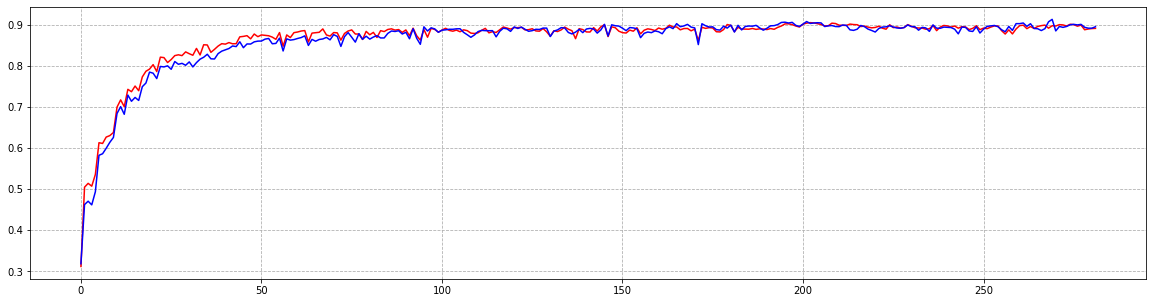

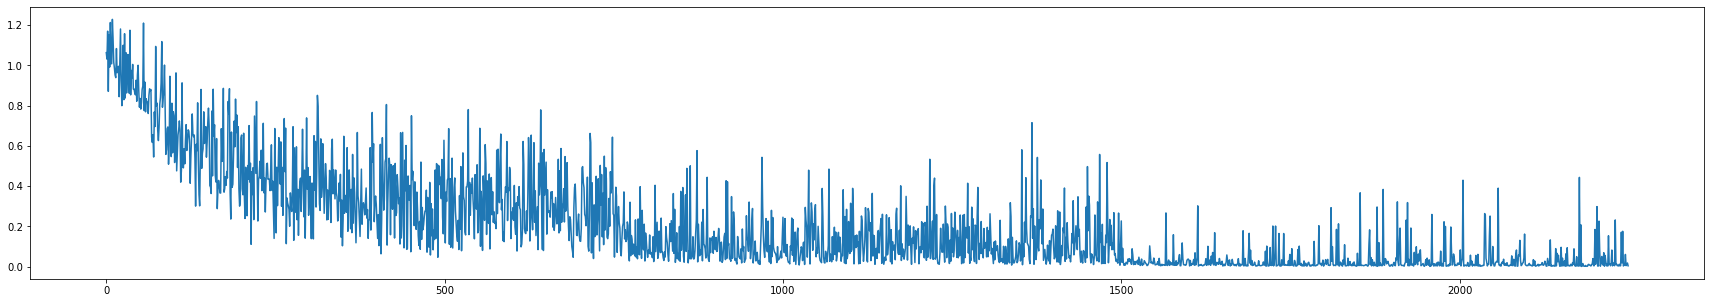

In [16]:
#train the bert classify model
if __name__ == '__main__':
    set_seed(0)  # Set all seeds to make results reproducible

    data_df = process_data(r'data\train.csv', classes2idx, True)

    train_df, val_df, test_df = train_test_split(data_df,valid_size=0.1, test_size=0.1, shuffle=True, random_state=1)
    #train_df, val_df, test_df = train_test_split(data_df,valid_size=0.2, test_size=0.2, shuffle=True)
    test_df.to_csv(r"data\test.csv", index=False, encoding='utf-8-sig')
    Loss_list = []
    times = []
    Accuracy_list = []
    Train_list = []
    Test_list = []
    print("Reading training data...")
    train_set = CustomDataset(train_df, maxlen=30, model_name=model_name)
    train_loader = Data.DataLoader(train_set, batch_size=batch_size, num_workers=0, shuffle=True)

    print("Reading validation data...")
    val_set = CustomDataset(val_df, maxlen=30, model_name=model_name)
    val_loader = Data.DataLoader(val_set, batch_size=batch_size, num_workers=0, shuffle=True)
    
    print("Reading test data...")
    test_set = CustomDataset(test_df, maxlen=30, model_name=model_name)
    test_loader = Data.DataLoader(test_set, batch_size=batch_size, num_workers=0, shuffle=True)


    
    model = MyModel(freeze_bert=False, model_name=model_name, hidden_size=768, num_classes=len(classes2idx))
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=5e-2)
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_model)
    print("save the first model")
    train_eval(model, criterion, optimizer, train_loader, val_loader, test_loader, epochs=3)
    test_data = r'data\test.csv'
    test_df = process_data(test_data, classes2idx, False)
    test_set = CustomDataset(test_df, maxlen=30, with_labels=False, model_name=model_name)
    classify_loader = Data.DataLoader(test_set, batch_size=batch_size, num_workers=0, shuffle=False)
    test(model, classify_loader, with_labels=False)
    
    
    plt.figure(figsize=(20, 5))
    plt.grid(linestyle="--")
    plt.plot(Accuracy_list,"r")
    plt.plot(Test_list,"blue")
    plt.show()
    plt.figure(figsize=(30, 5))
    plt.plot(Loss_list)
    plt.show()
    
    #classify the stock comments
    #classify_data = r'data\2021stockcomment.csv'
    #classify_df = process_data(classify_data, classes2idx, False)
    #classify_set = CustomDataset(classify_df, maxlen=30, with_labels=False, model_name=model_name)
    #classify_loader = Data.DataLoader(classify_set, batch_size=batch_size, num_workers=0, shuffle=False)
    #classify(model, classify_loader, with_labels=False)
    #print('classify the stock comments')

    
    #countdata()

In [18]:
Accuracy_list

[0.31183510638297873,
 0.504654255319149,
 0.5139627659574468,
 0.5070921985815603,
 0.5356826241134751,
 0.6128102836879432,
 0.6110372340425532,
 0.6265514184397163,
 0.6300975177304964,
 0.6376329787234043,
 0.699468085106383,
 0.7169769503546098,
 0.7005762411347518,
 0.742686170212766,
 0.7369237588652482,
 0.7506648936170213,
 0.7393617021276596,
 0.7728280141843971,
 0.7865691489361702,
 0.7918882978723404,
 0.8027482269503545,
 0.785904255319149,
 0.8209219858156029,
 0.819813829787234,
 0.807845744680851,
 0.8151595744680851,
 0.8246897163120567,
 0.8266843971631205,
 0.8246897163120567,
 0.8337765957446809,
 0.8293439716312057,
 0.8255762411347518,
 0.8421985815602837,
 0.8262411347517731,
 0.851063829787234,
 0.8506205673758864,
 0.832668439716312,
 0.839982269503546,
 0.8479609929078014,
 0.8537234042553191,
 0.8526152482269503,
 0.8563829787234043,
 0.8535017730496455,
 0.8537234042553191,
 0.870345744680851,
 0.8714539007092199,
 0.8732269503546098,
 0.8654698581560284,
 

In [17]:
countdata()

-----count data-----


100%|██████████| 13920/13920 [02:26<00:00, 95.03it/s]


In [19]:
Test_list

[0.3184840425531915,
 0.46232269503546103,
 0.47052304964539005,
 0.46165780141843976,
 0.49357269503546103,
 0.5822251773049645,
 0.5859929078014184,
 0.599290780141844,
 0.6136968085106383,
 0.6256648936170213,
 0.6839539007092199,
 0.7005762411347518,
 0.6819592198581561,
 0.7287234042553191,
 0.7136524822695035,
 0.7229609929078014,
 0.7156471631205673,
 0.749113475177305,
 0.7579787234042553,
 0.7845744680851063,
 0.7819148936170213,
 0.7688386524822695,
 0.7983156028368795,
 0.7972074468085106,
 0.7998670212765957,
 0.7914450354609929,
 0.8102836879432624,
 0.8036347517730497,
 0.8058510638297872,
 0.8011968085106383,
 0.8093971631205673,
 0.7972074468085106,
 0.8076241134751774,
 0.8160460992907801,
 0.8207003546099291,
 0.8280141843971631,
 0.8169326241134752,
 0.8164893617021277,
 0.8295656028368795,
 0.8355496453900709,
 0.8386524822695035,
 0.8419769503546098,
 0.8481826241134752,
 0.8466312056737588,
 0.8583776595744681,
 0.8439716312056738,
 0.8530585106382979,
 0.85283687

In [20]:
Loss_list

[1.0636203289031982,
 1.0317996740341187,
 1.1703537702560425,
 0.8714137673377991,
 1.1506073474884033,
 0.9923242330551147,
 1.2135628461837769,
 1.009335994720459,
 1.0084776878356934,
 1.2291784286499023,
 1.1330312490463257,
 1.016371726989746,
 0.9869775772094727,
 0.9525896310806274,
 0.9395262002944946,
 1.0840728282928467,
 0.9641577005386353,
 0.975031852722168,
 0.9958768486976624,
 0.8449284434318542,
 1.0052484273910522,
 1.1813251972198486,
 0.9241194725036621,
 0.8002673983573914,
 0.9232612252235413,
 1.1005926132202148,
 0.8299338817596436,
 1.1579121351242065,
 0.8384549617767334,
 1.063533067703247,
 0.8635593056678772,
 0.9271209836006165,
 1.0546566247940063,
 0.9326359629631042,
 0.8616847395896912,
 1.1750091314315796,
 0.8540257215499878,
 0.975138783454895,
 0.9384380578994751,
 1.005293369293213,
 0.8825446963310242,
 0.8834365606307983,
 0.8652404546737671,
 0.8542978763580322,
 0.9265952706336975,
 0.8223171830177307,
 0.9529538750648499,
 1.001109004020691,